In [173]:
# Uncomment following line and install this library

# !pip install summa

In [6]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
from google_trans_new import google_translator  
translator = google_translator()  

class STANDAARD():
    def __init__(self):
        self.session = requests.Session()
        self.url = 'https://www.standaard.be/nieuws/meest-recent'
        self.data = []
        self.headers = {"Accept-Language": "en-US,en"}
                
    def parse(self):
        response = self.session.get(self.url)        
        soup = bs(response.text, 'lxml')
        for category in soup.findAll('div', class_="articles-section-overview"):
            category_name = category.find('h6').text
            
            for link in category.findAll('a', class_='link-live')[0:2]:
                print(link['href'])
                self.get_article(link['href'], category_name)
        df = pd.DataFrame(self.data, columns=['category', 'title', 'article_intro', 'article_body',"By","Source"])
        df.to_csv('standaard.csv',mode="a", index=False)
                
    def get_article(self, link, category_name):
        response = self.session.get(link,headers= self.headers)
        soup = bs(response.text, 'lxml')
        
        try:
            title = soup.find('header', class_='article__header').find('h1').text
            title = translator.translate(title,lang_src='nl',lang_tgt='en')
            article_intro = soup.find('div', class_='intro').text.strip()
            article_intro = translator.translate(article_intro,lang_src='nl',lang_tgt='en')
            try:
                by = soup.find("footer",class_="article__meta").find("span").text.replace("(","",100).replace(")","",100)
                print(f"By : {by}")
            except:
                by = ""
            
            try:
                source = soup.find("span",class_="blend-in").text
                print(f"source : {source}")
            except:
                source = ""
            article_body = " ".join(p.text.strip() for p in soup.find('div', class_='article__body').findAll('p')[1:])
            article_body = translator.translate(article_body,lang_src='nl',lang_tgt='en')
            self.data.append([category_name, title, article_intro, article_body,by,source])
        except:
            pass

In [8]:
standaard = STANDAARD()
standaard.parse()

https://www.standaard.be/cnt/dmf20210413_91433472
By : cevt
source : Sciensano, Belga
https://www.standaard.be/cnt/dmf20210401_91683166
By : red
https://www.standaard.be/cnt/dmf20210413_91333544
By : BELGA
source : BELGA
https://www.standaard.be/cnt/dmf20210413_95142090
By : BELGA, Guardian
source : BELGA, Guardian
https://www.standaard.be/cnt/dmf20210412_94729181
By : sh
https://www.standaard.be/cnt/dmf20210412_95922863
https://www.standaard.be/cnt/dmf20210412_92192045
By : dc
https://www.standaard.be/cnt/dmf20210412_97476442
By : belga
source : belga
https://www.standaard.be/cnt/dmf20210412_94382311
By : Vincent Van Genechten


## Load Data From CSV

In [180]:
import pandas as pd
import numpy as np
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
  
#the stemmer requires a language parameter 
snow_stemmer = SnowballStemmer(language='dutch') 
stop_words = set(stopwords.words('dutch')) 

[nltk_data] Downloading package stopwords to /home/captin-
[nltk_data]     rao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [181]:
df = pd.read_csv('standaard.csv')
df.head()

,category,title,article_intro,article_body
0,Binnenland,Resultaten coronatests in twee Antwerpse wijke...,Vorige week werden 6.500 inwoners van twee buu...,Het aantal covid-19-besmettingen in de twee bu...
1,Binnenland,Coronablog | Frankrijk sluit grenzen voor reiz...,Volg hier alle recente ontwikkelingen over de ...,
2,Binnenland,Analyse | Alweer verandert een puzzelstuk van ...,De gebrekkige data over het AstraZeneca-vaccin...,Begin januari stelde de taskforce vaccinaties ...
3,Binnenland,Federale relanceplannen zijn klaar: van invest...,Premier Alexander De Croo (Open VLD) en staats...,"Van de 5,9 miljard Europese middelen die ons l..."
4,Binnenland,Motivatiebarometer staat stilaan op storm,De motivatiebaro­meter ziet er niet rooskleuri...,"‘Op ons tandvlees én toch volhouden’, zo vat h..."


In [182]:
df.article_body = df.article_body.replace(np.nan, '')

In [183]:
df.shape

(51, 4)

In [184]:
df.drop_duplicates(keep=False, inplace=True)
df.reset_index(inplace = True, drop = True)

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category       51 non-null     object
 1   title          51 non-null     object
 2   article_intro  51 non-null     object
 3   article_body   51 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [186]:
df['complete_article'] = df['title'].str.cat(df[['article_intro', 'article_body']], sep=' ')
df.head()

,category,title,article_intro,article_body,complete_article
0,Binnenland,Resultaten coronatests in twee Antwerpse wijke...,Vorige week werden 6.500 inwoners van twee buu...,Het aantal covid-19-besmettingen in de twee bu...,Resultaten coronatests in twee Antwerpse wijke...
1,Binnenland,Coronablog | Frankrijk sluit grenzen voor reiz...,Volg hier alle recente ontwikkelingen over de ...,,Coronablog | Frankrijk sluit grenzen voor reiz...
2,Binnenland,Analyse | Alweer verandert een puzzelstuk van ...,De gebrekkige data over het AstraZeneca-vaccin...,Begin januari stelde de taskforce vaccinaties ...,Analyse | Alweer verandert een puzzelstuk van ...
3,Binnenland,Federale relanceplannen zijn klaar: van invest...,Premier Alexander De Croo (Open VLD) en staats...,"Van de 5,9 miljard Europese middelen die ons l...",Federale relanceplannen zijn klaar: van invest...
4,Binnenland,Motivatiebarometer staat stilaan op storm,De motivatiebaro­meter ziet er niet rooskleuri...,"‘Op ons tandvlees én toch volhouden’, zo vat h...",Motivatiebarometer staat stilaan op storm De ...


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category          51 non-null     object
 1   title             51 non-null     object
 2   article_intro     51 non-null     object
 3   article_body      51 non-null     object
 4   complete_article  51 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB


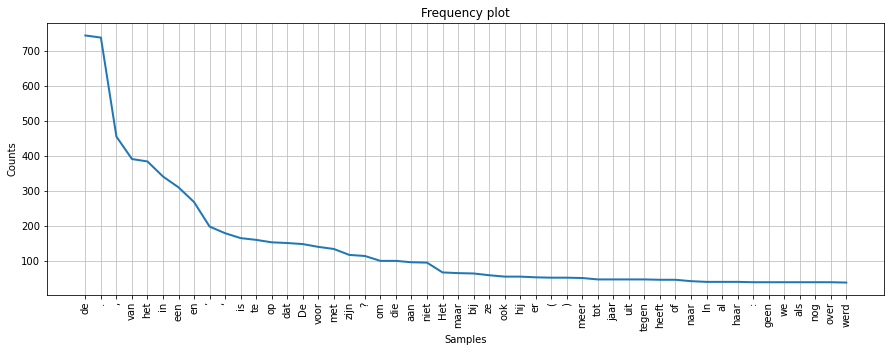

<AxesSubplot:title={'center':'Frequency plot'}, xlabel='Samples', ylabel='Counts'>

In [188]:
comment = ' '.join(df["complete_article"])
#function to split text into word
tokens = word_tokenize(comment)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)
plt.subplots(figsize=(15,5))
frequency_dist.plot(50,cumulative=False,title='Frequency plot')

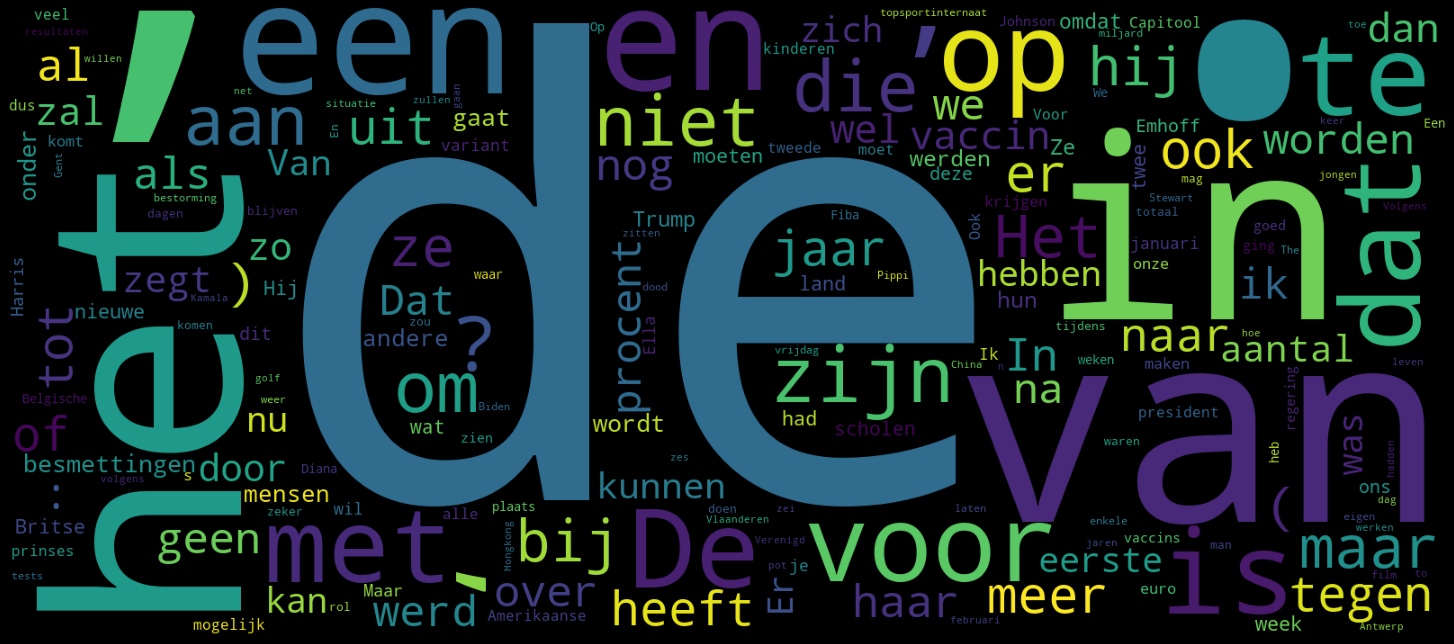

In [189]:
wordcloud = WordCloud(width=1600, height=700).generate_from_frequencies(frequency_dist)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [190]:
def clean_text(text,replace=''):
    text = re.sub(r'\d+', '', str(text))
    text = text.lower() # lowercase text
    text = ' '.join(snow_stemmer.stem(word) for word in text.split() if word not in stop_words)
    text = text.translate(str.maketrans('', '', string.punctuation)) #remove punctuation characters
    text = "".join(i for i in text if ord(i) < 128) #remove non-ascii characters
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', replace, text) #removes URL from string
    return text

In [191]:
df['complete_article'] = df['complete_article'].apply(clean_text)
df.drop_duplicates(keep=False, inplace=True)
df.reset_index(inplace = True, drop = True)
df.head()

,category,title,article_intro,article_body,complete_article
0,Binnenland,Resultaten coronatests in twee Antwerpse wijke...,Vorige week werden 6.500 inwoners van twee buu...,Het aantal covid-19-besmettingen in de twee bu...,resultat coronatest twee antwerp wijk bekend ...
1,Binnenland,Coronablog | Frankrijk sluit grenzen voor reiz...,Volg hier alle recente ontwikkelingen over de ...,,coronablog frankrijk sluit grenz reiziger bui...
2,Binnenland,Analyse | Alweer verandert een puzzelstuk van ...,De gebrekkige data over het AstraZeneca-vaccin...,Begin januari stelde de taskforce vaccinaties ...,analys alwer verandert puzzelstuk vaccinaties...
3,Binnenland,Federale relanceplannen zijn klaar: van invest...,Premier Alexander De Croo (Open VLD) en staats...,"Van de 5,9 miljard Europese middelen die ons l...",federal relanceplann klaar invester spor energ...
4,Binnenland,Motivatiebarometer staat stilaan op storm,De motivatiebaro­meter ziet er niet rooskleuri...,"‘Op ons tandvlees én toch volhouden’, zo vat h...",motivatiebarometer stat stilan storm motivatie...


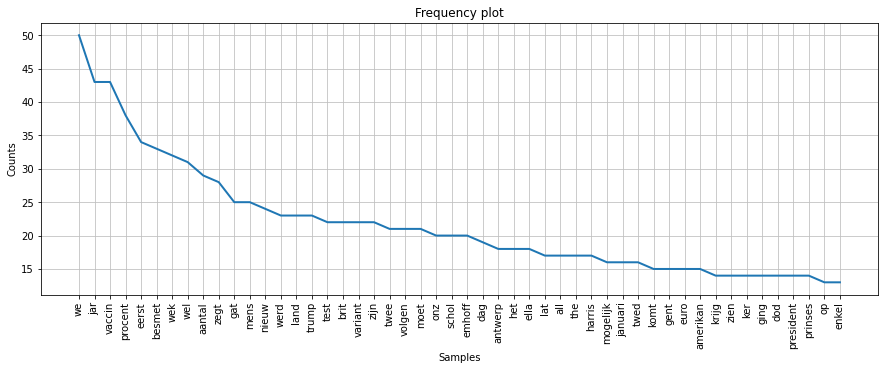

<AxesSubplot:title={'center':'Frequency plot'}, xlabel='Samples', ylabel='Counts'>

In [192]:
comment = ' '.join(df["complete_article"])
#function to split text into word
tokens = word_tokenize(comment)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)
plt.subplots(figsize=(15,5))
frequency_dist.plot(50,cumulative=False,title='Frequency plot')

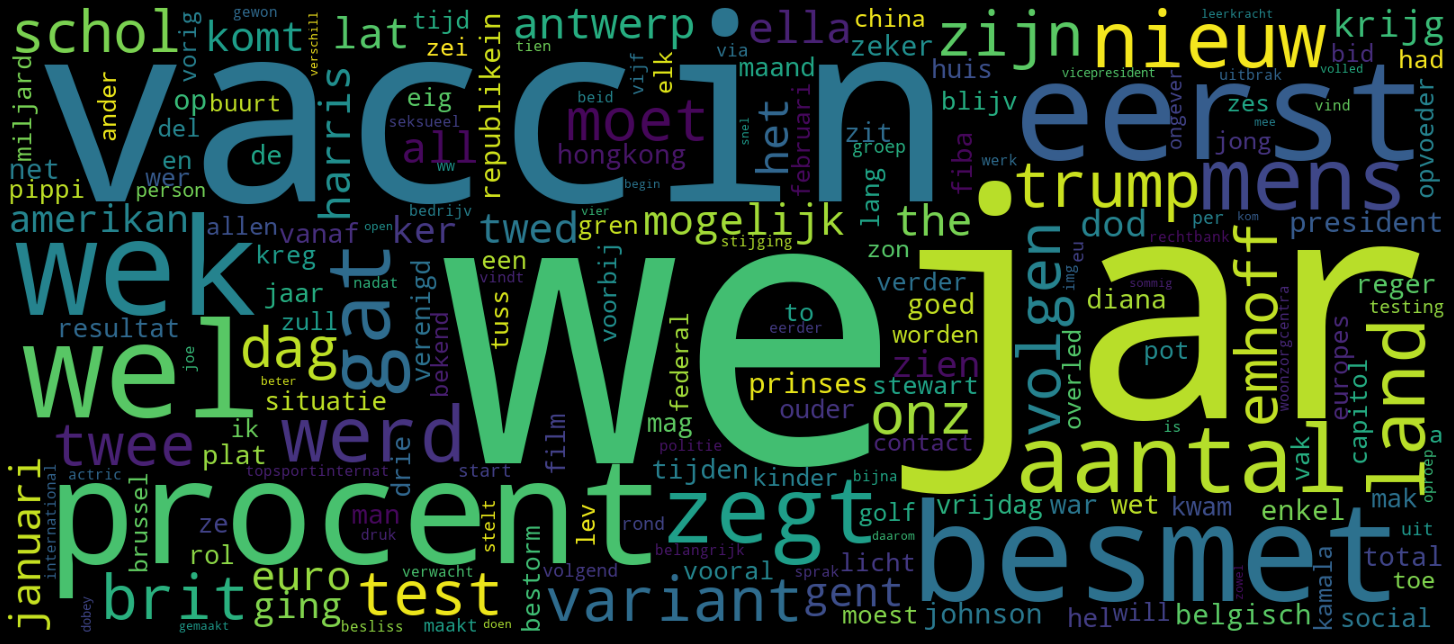

In [193]:
wordcloud = WordCloud(width=1600, height=700).generate_from_frequencies(frequency_dist)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Topic Modelling

In [194]:
countVectorizer = CountVectorizer()
termFrequency = countVectorizer.fit_transform(df.complete_article)
featureNames = countVectorizer.get_feature_names()

In [195]:
lda = LatentDirichletAllocation(n_components=3, max_iter=10)
lda.fit(termFrequency)

LatentDirichletAllocation(n_components=3)

In [196]:
nmf = NMF(n_components=3)
data_nmf = nmf.fit_transform(termFrequency) 

In [197]:
lsi = TruncatedSVD(n_components=3)
data_lsi = lsi.fit_transform(termFrequency)

In [198]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [199]:
print("LDA Model:")
selected_topics(lda, countVectorizer)

LDA Model:
Topic 0:
[('jar', 16.071277362276373), ('prinses', 14.333314081363866), ('vaccin', 14.320746851290329), ('the', 13.78168648565036), ('eerst', 12.855737233977358), ('diana', 12.333314044160147), ('film', 11.312370526678437), ('amerikan', 11.11919886691319), ('rol', 11.112656524502697), ('stewart', 10.333313992237095)]
Topic 1:
[('vaccin', 29.34587817053467), ('we', 26.89767006755707), ('procent', 24.34358753811335), ('besmet', 23.889875114896743), ('wel', 23.003953870060016), ('test', 22.318388477834784), ('wek', 21.01316842287042), ('aantal', 19.900869522441052), ('ella', 18.33329681051664), ('zegt', 18.014894854147013)]
Topic 2:
[('we', 15.788930600167282), ('euro', 14.33646356265624), ('jar', 13.19178277850593), ('nieuw', 12.33765250585689), ('gat', 11.914953952125263), ('moet', 11.07166307869884), ('reger', 10.349795633299493), ('opvoeder', 10.333314509071789), ('pippi', 10.33330761061406), ('eerst', 9.81413414262859)]


In [200]:
print("NMF Model:")
selected_topics(nmf, countVectorizer)

NMF Model:
Topic 0:
[('besmet', 2.1905123638534936), ('aantal', 1.9471046690759977), ('test', 1.7147046641715935), ('procent', 1.6574354202420265), ('we', 1.6242469759240301), ('mens', 1.1203869959724129), ('werd', 1.0557075981294948), ('brit', 0.9859247301195007), ('zegt', 0.90673014575277), ('variant', 0.8784196437851589)]
Topic 1:
[('vaccin', 3.7437975001157664), ('procent', 0.887650574971954), ('europes', 0.8783647689270065), ('ema', 0.8426387829541447), ('astrazeneca', 0.8426387829541447), ('ouder', 0.7600013180463342), ('johnson', 0.5992023411486346), ('variant', 0.5378302231061918), ('we', 0.4828360312478073), ('deelnemer', 0.4796837706415075)]
Topic 2:
[('ella', 0.9944743794674562), ('emhoff', 0.9602059846522631), ('ker', 0.8094493249269129), ('eerst', 0.7826240788790814), ('harris', 0.7709448332080209), ('wel', 0.7127290664660364), ('jar', 0.6991826447897945), ('trump', 0.6034037232027316), ('opvoeder', 0.5924164017014366), ('antwerp', 0.5912928948554098)]


## Text Summarization

In [201]:
data = pd.read_csv('standaard.csv')
data.head()

,category,title,article_intro,article_body
0,Binnenland,Resultaten coronatests in twee Antwerpse wijke...,Vorige week werden 6.500 inwoners van twee buu...,Het aantal covid-19-besmettingen in de twee bu...
1,Binnenland,Coronablog | Frankrijk sluit grenzen voor reiz...,Volg hier alle recente ontwikkelingen over de ...,
2,Binnenland,Analyse | Alweer verandert een puzzelstuk van ...,De gebrekkige data over het AstraZeneca-vaccin...,Begin januari stelde de taskforce vaccinaties ...
3,Binnenland,Federale relanceplannen zijn klaar: van invest...,Premier Alexander De Croo (Open VLD) en staats...,"Van de 5,9 miljard Europese middelen die ons l..."
4,Binnenland,Motivatiebarometer staat stilaan op storm,De motivatiebaro­meter ziet er niet rooskleuri...,"‘Op ons tandvlees én toch volhouden’, zo vat h..."


In [202]:
data.article_body = data.article_body.replace(np.nan, '')
data['complete_article'] = data['title'].str.cat(df[['article_intro', 'article_body']], sep=' ')
data.head()

,category,title,article_intro,article_body,complete_article
0,Binnenland,Resultaten coronatests in twee Antwerpse wijke...,Vorige week werden 6.500 inwoners van twee buu...,Het aantal covid-19-besmettingen in de twee bu...,Resultaten coronatests in twee Antwerpse wijke...
1,Binnenland,Coronablog | Frankrijk sluit grenzen voor reiz...,Volg hier alle recente ontwikkelingen over de ...,,Coronablog | Frankrijk sluit grenzen voor reiz...
2,Binnenland,Analyse | Alweer verandert een puzzelstuk van ...,De gebrekkige data over het AstraZeneca-vaccin...,Begin januari stelde de taskforce vaccinaties ...,Analyse | Alweer verandert een puzzelstuk van ...
3,Binnenland,Federale relanceplannen zijn klaar: van invest...,Premier Alexander De Croo (Open VLD) en staats...,"Van de 5,9 miljard Europese middelen die ons l...",Federale relanceplannen zijn klaar: van invest...
4,Binnenland,Motivatiebarometer staat stilaan op storm,De motivatiebaro­meter ziet er niet rooskleuri...,"‘Op ons tandvlees én toch volhouden’, zo vat h...",Motivatiebarometer staat stilaan op storm De ...


In [203]:
def clean_text(text):
    text = "".join(i for i in text if ord(i) < 128) #remove non-ascii characters
    return text

In [204]:
data['complete_article'] = data['complete_article'].apply(clean_text)

In [205]:
from summa.summarizer import summarize

In [206]:
def summarizer(text):
    summary = summarize(text)
    if len(summary) == 0:
        return text
    else:
        return summary

In [207]:
data['summary'] = data.complete_article.apply(summarizer)

In [208]:
data.summary

0     Resultaten coronatests in twee Antwerpse wijke...
1     Coronablog | Frankrijk sluit grenzen voor reiz...
2     Analyse | Alweer verandert een puzzelstuk van ...
3     Federale relanceplannen zijn klaar: van invest...
4     Snelle verbeteringen en versoepelingen zitten ...
5     Hij mag tien jaar geen beroep of hobby uitoefe...
6     Het is het derde vaccin, na Pfizer en Moderna,...
7     Dat betekent dat er kans is op lokale ijzel of...
8     Men mag niet sterven, alleen en verlaten in ee...
9     Vaccin Johnson & Johnson beschermt bij n dosis...
10    Wouter Deprez vertelt waarom hij meedoet aan C...
11    Vaccinaties in Vlaanderen op schema, maar de m...
12    Vanaf maandag sneltests voor bezoekers in woon...
13    Naar aanleiding van oproepen op de sociale med...
14    Meeste uitbraken in wzcs en bedrijven, daarna ...
15    Hele provincie kreeg fel gecontesteerde avondk...
16    Geraardsbergen test bijna 3.000 leerlingen en ...
17    Cartoon van de dag - januari 2021 Hoog tij

In [209]:
data.to_csv('standaard_summarization.csv', index=False)

## Sentiment Analysis

In [210]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import joblib
import pickle

In [211]:
df_sentiment = pd.read_csv("dutch_sentiment_data.csv")
df_sentiment.head()

,text,class
0,Meteen meegezogen in het verhaal. Mooie person...,positive
1,Kind 44 is 428 bladzijden lang,positive
2,een van de beste (misschien wel dé beste) thr...,positive
3,Wat een mooie en realistische roman van Rotter...,positive
4,spannend en verdrietig. De plot is niet erg v...,positive


In [212]:
df_sentiment.shape

(7046, 2)

<AxesSubplot:>

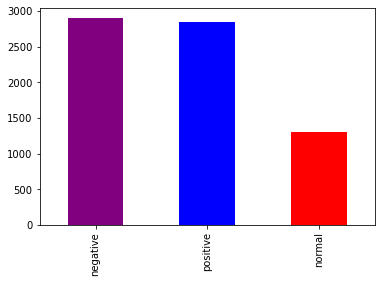

In [213]:
df_sentiment['class'].value_counts().plot.bar(color=['purple', 'blue', 'red'])

In [214]:
df_sentiment.text = df_sentiment.text.apply(clean_text)
df_sentiment.head()

,text,class
0,Meteen meegezogen in het verhaal. Mooie person...,positive
1,Kind 44 is 428 bladzijden lang,positive
2,een van de beste (misschien wel d beste) thri...,positive
3,Wat een mooie en realistische roman van Rotter...,positive
4,spannend en verdrietig. De plot is niet erg v...,positive


In [215]:
df_sentiment.dropna(inplace=True)
df_sentiment.drop_duplicates(inplace=True)
df_sentiment.reset_index(inplace=True, drop=True)
df_sentiment.shape

(7046, 2)

In [216]:
df_sentiment = df_sentiment.sample(frac=1)
df_sentiment.head()

,text,class
2871,Ik las in twee avonden tijd ruim tweehonderd b...,negative
2898,en heeft net een traumatische relatie met een...,negative
1090,dat je als ouders zo een kijkje krijgt in het ...,positive
518,fantasierijk en vooral een leuk verhaal wat l...,positive
6876,"Hallo John, ben net begonnen hier bij RWE Trad...",normal


### label encoding

In [217]:
label = LabelEncoder()
df_ = df_sentiment.copy()
df_['class'] = label.fit_transform(df_['class'])
df_.head()

,text,class
2871,Ik las in twee avonden tijd ruim tweehonderd b...,0
2898,en heeft net een traumatische relatie met een...,0
1090,dat je als ouders zo een kijkje krijgt in het ...,2
518,fantasierijk en vooral een leuk verhaal wat l...,2
6876,"Hallo John, ben net begonnen hier bij RWE Trad...",1


In [218]:
#Seperate data into feature and results
X, y = df_['text'], df_['class']

## uni-gram tf-idf vectorizer

In [219]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))

# TF-IDF BASED FEATURE REPRESENTATION
train_feature_set=tfidf.fit_transform(X)

In [220]:
pickle.dump(tfidf, open("vectorizer.pickle", "wb"))

## Train SVM Model

In [221]:
svm = SVC(kernel='linear')

svm.fit(train_feature_set,y)

SVC(kernel='linear')

## save trained model

In [222]:
filename = 'finalized_model.sav'
joblib.dump(svm, filename)

['finalized_model.sav']

In [223]:
articles_features = tfidf.transform(df.complete_article)

In [224]:
y_pred = svm.predict(articles_features)

In [229]:
y_pred = label.inverse_transform(y_pred)

In [230]:
df["pred_sentiment"] = y_pred

<AxesSubplot:>

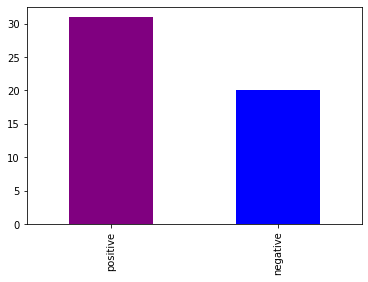

In [231]:
df.pred_sentiment.value_counts().plot.bar(color=['purple', 'blue', 'red'])

In [232]:
df.to_csv('standaard_predicted_sentiment.csv', index=True)